In [ ]:
import numpy as np

def compute_rmsd_to_ends(path):
    """
    Compute RMSD to aligned start and end frames for each frame in a trajectory.
    path: array of coordinates (T, N, 3), where:
        T: number of frames (time steps),
        N: number of atoms or beads per frame,
        3: x, y, z coordinates.
    """
    def kabsch_rmsd(P, Q):
        """
        helper function that computes RMSD between two point sets, P and Q, after optimal alignment using the Kabsch algorithm
        """
        # translate both point sets to their center of mass, so RMSD is not affected by position
        P_centered = P - P.mean(axis=0)
        Q_centered = Q - Q.mean(axis=0)

        # calculate the covariance matrix between centered P and Q
        C = np.dot(P_centered.T, Q_centered)
        V, _, Wt = np.linalg.svd(C) # Singular Value Decomposition (SVD) on C, used to compute the optimal rotation matrix
        d = np.sign(np.linalg.det(np.dot(V, Wt))) # ensures that the rotation matrix preserves right-handedness (avoids improper reflection), if the determinant is negative, it flips one axis
        U = np.dot(V, np.dot(np.diag([1,1,d]), Wt)) # compute the optimal rotation matrix U using the SVD components, this matrix rotates P_centered to best align with Q_centered

        # applies the rotation U to P_centered to produce the aligned point set
        P_rot = np.dot(P_centered, U)

        # Compute the RMSD between the rotated P and Q
            # (P_rot - Q_centered) ** 2: squared difference per atom
            # sum(..., axis=1): squared distance per atom
            # mean(...): mean squared distance over all atoms
            # sqrt(...): root of that mean = RMSD
        return np.sqrt(np.mean(np.sum((P_rot - Q_centered) ** 2, axis=1)))
    
    # select the start frame and end frame of the path for comparison
    start = path[0]
    end = path[-1]

    # storage lists to store RMSD values
    rmsd_to_start = []
    rmsd_to_end = []

    for frame in path: # loop through each frame in the path
        rmsd_to_start.append(kabsch_rmsd(frame, start)) # aligns to the start frame and computes RMSD, appending the result
        rmsd_to_end.append(kabsch_rmsd(frame, end)) # aligns to the end frame and computes RMSD, appending the result

    return np.array(rmsd_to_start), np.array(rmsd_to_end) # converts both RMSD lists to numpy arrays and return them


In [ ]:
def load_xyz_trajectory(file_path, n_atoms):
    """
    function to load XYZ trajectory data from a file.
        file_path: path to the .xyz file.
        n_atoms: the number of atoms per frame
    """
    frames = [] # list to store all frames

    with open(file_path, 'r') as f: # open the given file in read mode
        lines = f.readlines() # reads all lines of the file as a list of strings
        lines_per_frame = n_atoms + 2  # computes how many lines correspond to a single frame, the format used in the inference code is 1st line: number of atoms, 2nd line: comment line (ignored) followed by n_atoms lines of atom coordinates

        for i in range(0, len(lines), lines_per_frame): # iterates over the file in chunks of one frame, from 0 to total number of lines, in steps of lines_per_frame
            frame_lines = lines[i+2:i+2+n_atoms]  # extracts only the coordinate lines, skipping the two lines at the beginning of each frame
            coords = [] # list to hold the atomic coordinates for this frame
            for line in frame_lines: # iterates over the lines corresponding to atoms in this frame
                parts = line.strip().split() # split the line into components (atom_name, x, y, z)
                coords.append([float(x) for x in parts[1:]])  # converts the x, y, z strings into floats and stores them, ignoring the atom name
            frames.append(coords) # append the full list of 3D coordinates for this frame

    return np.array(frames)  # convert the list of frames into a NumPy array and returns it


In [ ]:
import numpy as np
import mdtraj as md

def coarse_grain_traj_ordered(mdcrd_path, prmtop_file, atomic_weights, CG_BASES, BEAD_ORDER, PO5_BOND_LENGTH=0.1615):
    """
    function to process an all-atom path into a coarse-grained path
        mdcrd_path: path to the MD trajectory file (.mdcrd)
        prmtop_file: topology file needed to interpret atom types and residues
        atomic_weights: dict of atomic weights (e.g. {"H": 1.008, "C": 12.01, ...})
        CG_BASES: mapping of base bead names to their atoms
        BEAD_ORDER: dict mapping each residue type to the desired bead order
        PO5_BOND_LENGTH: default length to extend from HO5' -> O5' to estimate P in the first residue
    """
    # load the path using MDTraj and extract its topology and number of frames
    traj = md.load_mdcrd(mdcrd_path, top=prmtop_file)
    top = traj.topology
    n_frames = traj.n_frames

    cg_frames = [] # list to store the CG coordinates for each residue
    for res in top.residues: # iterate through all residues in the path
        atom_map = {a.name: a.index for a in res.atoms} # build a mapping from atom names to indices
        resname = res.name.strip()[0]  # extract residue name, e.g., "A", "C"

        if resname not in BEAD_ORDER: # skip residues that aren't included in the defined CG bead order
            continue

        bead_order = BEAD_ORDER[resname] # get the expected order of CG beads for this residue
        bead_dict = {} # dictionary to hold computed bead coordinates

        # backbone building
        # P bead
        if res.index == 0 and "HO5'" in atom_map and "O5'" in atom_map: # for the first residue only, use HO5' and O5' to estimate the position of the first phosphate (P) bead
            ho5 = traj.xyz[:, atom_map["HO5'"], :] # extract HO5' coordinates across all frames
            o5 = traj.xyz[:, atom_map["O5'"], :] # extract O5' coordinates across all frames
            direction = o5 - ho5 # compute vector pointing from HO5' to O5'
            unit_vec = direction / (np.linalg.norm(direction, axis=1, keepdims=True) + 1e-8) # normalize vector to remove magnitude
            p_bead = o5 + unit_vec * PO5_BOND_LENGTH # place the P bead along the extension of HO5'–O5', at a fixed bond length
            bead_dict["P"] = p_bead # save position to dictionary
        elif "P" in atom_map: # for all non-first residues, just take the actual P atom position
            bead_dict["P"] = traj.xyz[:, atom_map["P"], :]

        #  Extract and store backbone sugar atom coordinates (O5', C5', C4', C1')
        for name in ["O5'", "C5'", "C4'", "C1'"]:
            if name in atom_map: # check for it in atom map
                bead_dict[name] = traj.xyz[:, atom_map[name], :] # extract position

        # base bead calculations
        
        base_tags = [f"{resname}1", f"{resname}2"] if resname in ("A", "G") else [f"{resname}1"] # set which base beads to extract, purines (A, G) get two base beads X1 and X2, pyrimidines (C, U) get X1

        # collect atoms for the current base bead
        for idx, tag in enumerate(base_tags): # loop for determined number of base beads (1 or 2)
            coords_list, elements_list = [], [] # storage lists for coordinates and elements
            if tag not in CG_BASES: # skip if the tag isn’t defined in the CG base atom dictionary
                continue
            for at in CG_BASES[tag]: # for each atom in the CG base group
                if at in atom_map: # check for it in atom map
                    coords_list.append(traj.xyz[:, atom_map[at], :]) # get atom coordinates across all frames
                    elements_list.append(top.atom(atom_map[at]).element.symbol) # get atom element type for mass-weighted averaging

            # compute mass-weighted center of mass across the base atoms per frame
            if coords_list:
                coords = np.stack(coords_list, axis=1) # get coordinates for calculation
                com = np.array([
                    np.average(coords[i], axis=0, weights=[atomic_weights[e] for e in elements_list])
                    for i in range(n_frames)
                ])
                bead_dict[f"X{idx+1}"] = com  # Store as "X1" and "X2" depending on idx

        # collect beads
        residue_beads = [] # storage list for beads
        for bead_name in bead_order: # for each expected bead in the ordered list
            if bead_name in bead_dict:
                bead = bead_dict[bead_name] # add actual bead
            else:
                # insert NANs if bead is missing
                bead = np.full((n_frames, 3), np.nan)
            residue_beads.append(bead[:, None, :])  # expand dimensions to (n_frames, 1, 3) for stacking later

        residue_coords = np.concatenate(residue_beads, axis=1)  # stack all beads for this residue into one array and store it
        cg_frames.append(residue_coords)

    # concatenate along beads axis, forming the final CG [path
    final_cg = np.concatenate(cg_frames, axis=1)  # shape: (n_frames, total_beads, 3)
    return final_cg


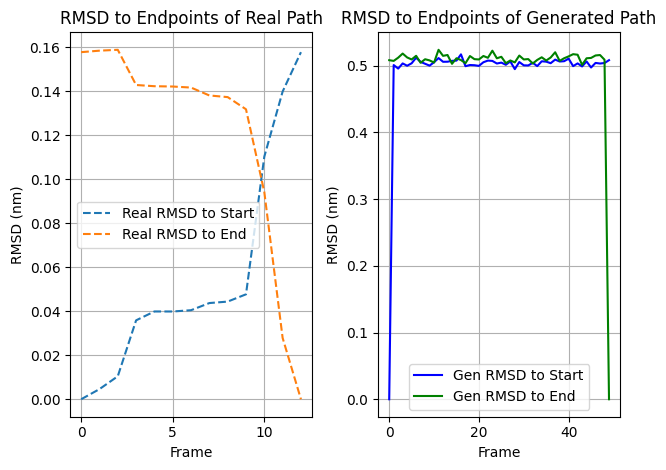

In [ ]:
# USE THIS BLOCK FOR ALL-ATOM COORDINATE REAL AND GENERATED PATHWAYS
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

topology_file = 'C:/Users/ckcho/OneDrive/Desktop/KCL Bioinformatics/Research_project/PK1/coords.prmtop'

# 'real_path' and 'generated_path' are coordinate numpy arrays
# Load the real path  and extract XYZ coordinates
real_traj = md.load_mdcrd('C:/Users/ckcho/OneDrive/Desktop/KCL Bioinformatics/Research_project/Paths/path5.mdcrd', top=topology_file)
real_path = real_traj.xyz  # shape: (n_frames, n_atoms, 3)

# load in generated path and get XYZ coordinates
generated_traj = md.load_xyz('C:/Users/ckcho/OneDrive/Desktop/KCL Bioinformatics/Research_project/Diffusion_model/Generated_paths/generated_path_attention.xyz', top=topology_file )
generated_path = generated_traj.xyz

# compute RMSD 
real_rmsd_start, real_rmsd_end = compute_rmsd_to_ends(real_path)
gen_rmsd_start, gen_rmsd_end = compute_rmsd_to_ends(generated_path)

# Plotting 
import matplotlib.pyplot as plt

# real path plot
figure, axis = plt.subplots(1, 2)
axis[0].plot(real_rmsd_start, label="Real RMSD to Start", linestyle='--')
axis[0].plot(real_rmsd_end,   label="Real RMSD to End", linestyle='--')
axis[0].set_xlabel("Frame")
axis[0].set_ylabel("RMSD (nm)")
axis[0].set_title("RMSD to Endpoints of Real Path")
axis[0].legend()
axis[0].grid(True)

# generated path plot
axis[1].plot(gen_rmsd_start, label="Gen RMSD to Start", color='blue')
axis[1].plot(gen_rmsd_end,   label="Gen RMSD to End", color='green')
axis[1].set_xlabel("Frame")
axis[1].set_ylabel("RMSD (nm)")
axis[1].set_title("RMSD to Endpoints of Generated Path")
axis[1].legend()
axis[1].grid(True)

plt.tight_layout()
plt.show()


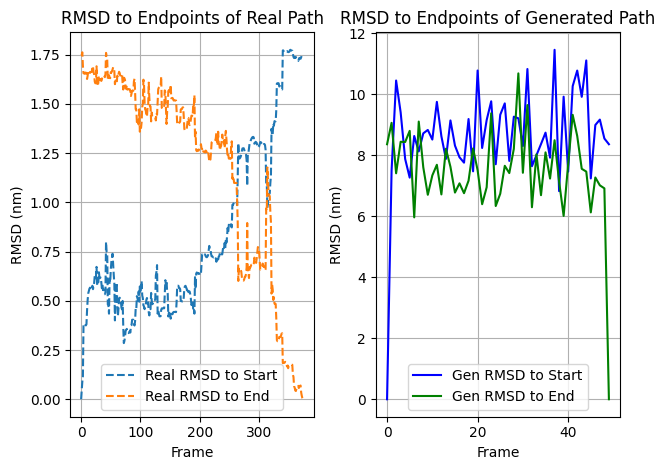

In [ ]:
# USE THIS BLOCK FOR COARSE-GRAINED PATHWAYS GENERATED BY THE CG MODLE AND DIHEDRAL MODEL
import mdtraj as md

topology_file = 'C:/Users/ckcho/OneDrive/Desktop/KCL Bioinformatics/Research_project/PK1/coords.prmtop'

# Load the real trajectory (MDCRD) and extract XYZ coordinates
real_traj = md.load_mdcrd('C:/Users/ckcho/OneDrive/Desktop/KCL Bioinformatics/Research_project/Paths/path5.mdcrd', top=topology_file)

atomic_weights = {"C": 12.011, "N": 14.007, "O": 16.000}
PO5_BOND_LENGTH = 0.1615
CG_BASES = {  # ← your base atom dictionary
    "A1": ["N7", "N9", "C4", "C5", "C8"],
    "A2": ["N1", "C2", "N3", "C4", "C5", "N6", "C6"],
    "C1": ["N1", "C2", "N3", "N4", "C4", "C5", "C6", "O2"],
    "G1": ["N7", "N9", "C4", "C5", "C8"],
    "G2": ["N1", "N2", "C2", "N3", "C4", "C5", "C6", "O6"],
    "T1": ["N1", "C2", "N3", "C4", "C5", "C6", "O2", "O4"],
    "U1": ["N1", "C2", "N3", "C4", "C5", "C6", "O2", "O4"]
}
BEAD_ORDER = {
    "A": ["P", "O5'", "C5'", "C4'", "C1'", "X1", "X2"],
    "G": ["P", "O5'", "C5'", "C4'", "C1'", "X1", "X2"],
    "C": ["P", "O5'", "C5'", "C4'", "C1'", "X1"],
    "U": ["P", "O5'", "C5'", "C4'", "C1'", "X1"],
    "T": ["P", "O5'", "C5'", "C4'", "C1'", "X1"]}

# 'real_path' and 'generated_path' are coordinate numpy arrays
real_path = real_traj.xyz  # shape: (n_frames, n_atoms, 3)
cg_real_path = coarse_grain_traj_ordered('C:/Users/ckcho/OneDrive/Desktop/KCL Bioinformatics/Research_project/Paths/path20.mdcrd', topology_file, atomic_weights, CG_BASES, BEAD_ORDER)

path = 'C:/Users/ckcho/OneDrive/Desktop/KCL Bioinformatics/Research_project/Diffusion_model/Dihedral_model/generated_path_dihedral_3.xyz'
n_atoms = 143  # set this manually based on your CG model
generated_path = load_xyz_trajectory(path, n_atoms)

real_rmsd_start, real_rmsd_end = compute_rmsd_to_ends(cg_real_path)
gen_rmsd_start, gen_rmsd_end = compute_rmsd_to_ends(generated_path)

# Plotting 
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)
axis[0].plot(real_rmsd_start, label="Real RMSD to Start", linestyle='--')
axis[0].plot(real_rmsd_end,   label="Real RMSD to End", linestyle='--')
axis[0].set_xlabel("Frame")
axis[0].set_ylabel("RMSD (nm)")
axis[0].set_title("RMSD to Endpoints of Real Path")
axis[0].legend()
axis[0].grid(True)

axis[1].plot(gen_rmsd_start, label="Gen RMSD to Start", color='blue')
axis[1].plot(gen_rmsd_end,   label="Gen RMSD to End", color='green')
axis[1].set_xlabel("Frame")
axis[1].set_ylabel("RMSD (nm)")
axis[1].set_title("RMSD to Endpoints of Generated Path")
axis[1].legend()
axis[1].grid(True)

plt.tight_layout()
plt.show()
